In [1]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
torch.cuda.is_available()

True

In [4]:
GAN_LOGS = os.path.join(os.getcwd(), "Lab Work/CUDA_Assignment_6/tboard_logs", "gan")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)

In [5]:
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [6]:
if not os.path.exists("Lab Work/CUDA_Assignment_6/imgs"):
    os.makedirs("Lab Work/CUDA_Assignment_6/imgs")
if os.path.exists("Lab Work/CUDA_Assignment_6/imgs/training"):
    shutil.rmtree("Lab Work/CUDA_Assignment_6/imgs/training")
if not os.path.exists("Lab Work/CUDA_Assignment_6/imgs/training"):
    os.makedirs("Lab Work/CUDA_Assignment_6/imgs/training")

In [7]:
# Downloading and Loading Dataset
SVHN_tf = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomRotation(10),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

train_dataset = datasets.SVHN(root='/home/user/krishnanm0/data/SVHN', split='train', transform=SVHN_tf, download=True)
test_dataset = datasets.SVHN(root='/home/user/krishnanm0/data/SVHN', split='test', transform=SVHN_tf, download=True)

Using downloaded and verified file: /home/user/krishnanm0/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/user/krishnanm0/data/SVHN/test_32x32.mat


In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=4, drop_last=True) 

In [9]:
for i,j in train_loader:
    print(i.shape,j.shape)
    break

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [10]:
imgs = next(iter(train_loader))[0]

## Convolutional GAN

 - Following the DC-GAN Architecture

In [11]:
class ConvBlock(nn.Module):
    """
    Simple convolutional block: Conv + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, add_norm=True, activation="ReLU", dropout=None, pad = 1):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Sigmoid", "Tanh", None]
        
        block = []
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=pad, stride=stride))
        if add_norm:
            block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
            
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x):
        """ Forward pass """
        y = self.block(x)
        return y


class ConvTransposeBlock(nn.Module):
    """
    Simple convolutional block: ConvTranspose + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, add_norm=True, activation="ReLU", dropout=None, pad =1):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Tanh", None]
        
        
        block = []
        block.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=pad, stride=stride))
        if add_norm:
            block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x):
        """ Forward pass """
        y = self.block(x)
        return y


class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)


In [12]:
class Reshape(nn.Module):
    """ Reshaping a vector in a given shape """
    
    def __init__(self, shape):
        """ """
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        """ """
        B, N = x.shape
        x = x.view(B, N, 1, 1)
        y = x.repeat(1, 1, *self.shape)
        return y

In [13]:
class Generator(nn.Module):
    """
    A fully convolutional generator using ReLU activations. 
    Takes as input a latent vector and outputs a fake sample.
       (B, latent_dim, 1, 1)  --> (B, num_channels, 32, 32)
    """
    def __init__(self, latent_dim=102, num_classes=10, num_channels=1, base_channels=32, embedding_dim = 16):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        input_dim = latent_dim + embedding_dim

        self.pixel_norm = PixelNorm()

        layers = []
        for i in range(3):
            layers.append(
                ConvTransposeBlock(
                    in_channels=input_dim if i == 0 else base_channels * 2 ** (2 - i + 1),
                    out_channels=base_channels * 2 ** (2 - i),
                    kernel_size=4,
                    stride=1 if i == 0 else 2,
                    add_norm=True,
                    activation="ReLU",
                    pad = 0 if i == 0 else 1
                )              
            )
        
        layers.append(
            ConvTransposeBlock(
                in_channels=base_channels,
                out_channels=num_channels,
                kernel_size=4,
                stride=2,
                add_norm=False,
                activation="Tanh"
            )
        )
        

        self.model = nn.Sequential(*layers)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        
    def forward(self, z, labels):
        label_embeddings = self.label_embedding(labels)  # Shape: [batch_size, latent_dim]
        # label_embeddings = label_embeddings.unsqueeze(2).unsqueeze(3)  # Shape: [batch_size, latent_dim, 1, 1]
        z = z.reshape([z.shape[0], -1, 1, 1])
        label_embeddings = label_embeddings.reshape([label_embeddings.shape[0], -1, 1, 1])
        z = torch.cat([z, label_embeddings], dim=1) 
        z = self.pixel_norm(z)
        return self.model(z)

In [14]:
generator = Generator(latent_dim=128, num_channels=1, base_channels=32)
print(generator)

Generator(
  (label_embedding): Embedding(10, 16)
  (pixel_norm): PixelNorm()
  (model): Sequential(
    (0): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(144, 128, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(32, 1, kernel

In [15]:
class Discriminator(nn.Module):
    """ A fully convolutional discriminator using LeakyReLU activations. 
    Takes as input either a real or fake sample and predicts its autenticity.
       (B, num_channels, 32, 32)  -->  (B, 1, 1, 1)
    """
    def __init__(self, in_channels=1, num_classes=10, out_dim=1, base_channels=32, dropout=0.3, embedding_dim = 32):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.label_embedding = nn.Embedding(num_classes, embedding_dim ** 2)

        input_channels = in_channels + 1

        layers = []
        for i in range(3):
            layers.append(
                ConvBlock(
                    in_channels=input_channels if i == 0 else base_channels * 2 ** (i-1),
                    out_channels=base_channels * 2 ** (i ),
                    kernel_size=4,
                    add_norm=True,
                    activation="LeakyReLU",
                    dropout=dropout,
                    stride=2
                )
            )
        layers.append(
            ConvBlock(
                in_channels=base_channels * 4,
                out_channels=out_dim,
                kernel_size=4,
                stride=1,
                add_norm=False,
                activation="Sigmoid",
                pad = 0
            )
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, labels):
        label_embeddings = self.label_embedding(labels)  # Shape: [batch_size, embedding_dim]
        # label_embeddings = label_embeddings.unsqueeze(2).unsqueeze(3)  # Shape: [batch_size, embedding_dim, 1, 1]
        # label_embeddings = label_embeddings.expand(-1, -1, x.size(2), x.size(3))  # Expand to match x's spatial dimensions
        label_embeddings = label_embeddings.reshape([label_embeddings.shape[0], 1, 32, 32])
        x = torch.cat([x, label_embeddings], dim=1)
        return self.model(x)

In [16]:
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=32)
print(discriminator)

Discriminator(
  (label_embedding): Embedding(10, 1024)
  (model): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout

In [17]:
generator = Generator(latent_dim=10, num_channels=3, base_channels=64, embedding_dim=5)
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=64)

In [18]:
latent = torch.randn(16, 10, 1, 1)
labels = torch.randint(0,10,(16,))
fake_img = generator(latent,labels)
print(fake_img.shape)
score = discriminator(fake_img,labels)
print(f"{fake_img.shape = }")
print(f"{score.shape = }")

torch.Size([16, 3, 32, 32])
fake_img.shape = torch.Size([16, 3, 32, 32])
score.shape = torch.Size([16, 1, 1, 1])


## Training Code

In [19]:
# utils
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(loss_iters, train_loss, val_loss):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("log")
    ax[0].set_title("Training Progress")

    smooth_loss = smooth(loss_iters, 31)
    START = 500
    N_ITERS = len(loss_iters)
    ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title(f"Training Progress from Iter {START}")

    epochs = np.arange(len(train_loss)) + 1
    ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
    ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_title("Loss Curves")


In [20]:
class Trainer:
    """
    Class for initializing GAN and training it
    """
    def __init__(self, generator, discriminator, latent_dim=128, num_classes=10, writer=None):
        assert writer is not None, "Tensorboard writer not set..."

        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.writer = writer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)

        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.99), weight_decay=2e-5)
        self.scheduler_discriminator = torch.optim.lr_scheduler.StepLR(self.optim_discriminator, step_size=5, gamma=0.9)
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.99), weight_decay=2e-5)
        self.scheduler_generator = torch.optim.lr_scheduler.StepLR(self.optim_generator, step_size=5, gamma=0.9)

        self.criterion_g = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_real = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_fake = lambda pred: F.binary_cross_entropy(pred, torch.zeros(pred.shape[0], device=pred.device))

        self.img_labels = torch.randint(0,10,(64,))

        self.hist = {
            "d_real": [],
            "d_fake": [],
            "g": []
        }

    def train_one_step(self, imgs, labels):
        self.generator.train()
        self.discriminator.train()

        B = imgs.shape[0]
        latent = torch.randn(B, self.latent_dim, 1, 1).to(self.device)
        labels = labels.to(self.device)

        self.optim_discriminator.zero_grad()
        prediction_real = self.discriminator(imgs, labels)
        d_loss_real = self.criterion_d_real(prediction_real.view(B))

        fake_samples = self.generator(latent, labels)
        prediction_fake_d = self.discriminator(fake_samples.detach(), labels)
        d_loss_fake = self.criterion_d_fake(prediction_fake_d.view(B))
        (d_loss_real + d_loss_fake).backward()

        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        self.optim_discriminator.step()

        self.optim_generator.zero_grad()
        prediction_fake_g = self.discriminator(fake_samples, labels)
        g_loss = self.criterion_g(prediction_fake_g.view(B))
        g_loss.backward()

        self.optim_generator.step()

        return d_loss_real, d_loss_fake, g_loss

    @torch.no_grad()
    def generate(self, labels, N=64):
        self.generator.eval()
        latent = torch.randn(N, self.latent_dim, 1, 1).to(self.device)
        labels = labels.to(self.device)
        imgs = self.generator(latent, labels)
        imgs = imgs * 0.5 + 0.5
        return imgs

    def train(self, data_loader, N_iters=10000, init_step=0):
        progress_bar = tqdm(total=N_iters, initial=init_step)
        running_d_loss = 0
        running_g_loss = 0

        iter_ = 0
        for i in range(N_iters):
            for real_batch, labels in data_loader:
                real_batch = real_batch.to(self.device)
                d_loss_real, d_loss_fake, g_loss = self.train_one_step(imgs=real_batch, labels=labels)
                d_loss = d_loss_real + d_loss_fake

                progress_bar.set_description(f"Ep {i+1} Iter {iter_} : D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                progress_bar.update(1)
                self.writer.add_scalar(f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
                self.writer.add_scalar(f'Loss/Discriminator Loss', d_loss.item(), global_step=iter_)
                self.writer.add_scalars(f'Loss/Discriminator Losses', {
                    "Real Images Loss": d_loss_real.item(),
                    "Fake Images Loss": d_loss_fake.item(),
                }, global_step=iter_)
                self.writer.add_scalars(f'Comb_Loss/Losses', {
                    'Discriminator': d_loss.item(),
                    'Generator': g_loss.item()
                }, iter_)
                if(iter_ % 200 == 0):
                    imgs = self.generate(labels=self.img_labels)
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    self.writer.add_image('images', grid, global_step=iter_)
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "Lab Work/CUDA_Assignment_6/imgs", "training", f"imgs_{iter_}.png"))

                iter_ = iter_ + 1
            # self.scheduler_discriminator.step()
            # self.scheduler_generator.step()

In [21]:
#2.0 had increased latent features
#2.1 has extended CNN, and dropout added in the generator
GAN_LOGS = os.path.join(os.getcwd(), "Lab Work/CUDA_Assignment_6/tboard_logs", "cDCGAN_v2.1")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [22]:
from tqdm import tqdm

In [23]:
generator = Generator(latent_dim=10, num_channels=3, base_channels=64, embedding_dim=5)
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=64)

trainer = Trainer(generator=generator, discriminator=discriminator, latent_dim=10, writer=writer)

In [24]:
trainer.train(data_loader=train_loader)

  0%|                                                                                                                                      | 0/10000 [00:00<?, ?it/s]

/home/user/krishnanm0/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/user/krishnanm0/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Ep 49 Iter 13811 : D_Loss=1.03808, G_Loss=1.58923): : 13812it [06:19, 34.52it/s]                                                                                     

KeyboardInterrupt: 

Ep 49 Iter 13811 : D_Loss=1.03808, G_Loss=1.58923): : 13812it [06:30, 34.52it/s]

### Making gif

In [25]:
import imageio

images = []
img_path = os.path.join(os.getcwd(), "Lab Work/CUDA_Assignment_6/imgs", "training")

# making list with images and orting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(x.split("_")[1].split(".")[0]))

In [26]:
for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))
imageio.mimsave(os.path.join(img_path, "progress.gif"), images)

/tmp/ipykernel_1759351/2465386924.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(img_path, img)))


### Generating some Images

In [27]:
labels=torch.randint(0,10,(64,))
imgs = trainer.generate(labels=labels)
grid = torchvision.utils.make_grid(imgs, nrow=8)
grid.shape

torch.Size([3, 274, 274])

In [28]:
labels

tensor([6, 1, 1, 2, 8, 9, 9, 3, 7, 5, 7, 5, 2, 1, 0, 1, 6, 0, 5, 7, 6, 5, 8, 3,
        5, 9, 3, 4, 0, 4, 3, 0, 7, 9, 8, 8, 9, 4, 4, 2, 3, 4, 3, 3, 7, 3, 2, 2,
        6, 8, 3, 0, 8, 1, 3, 5, 6, 6, 3, 8, 0, 6, 8, 9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


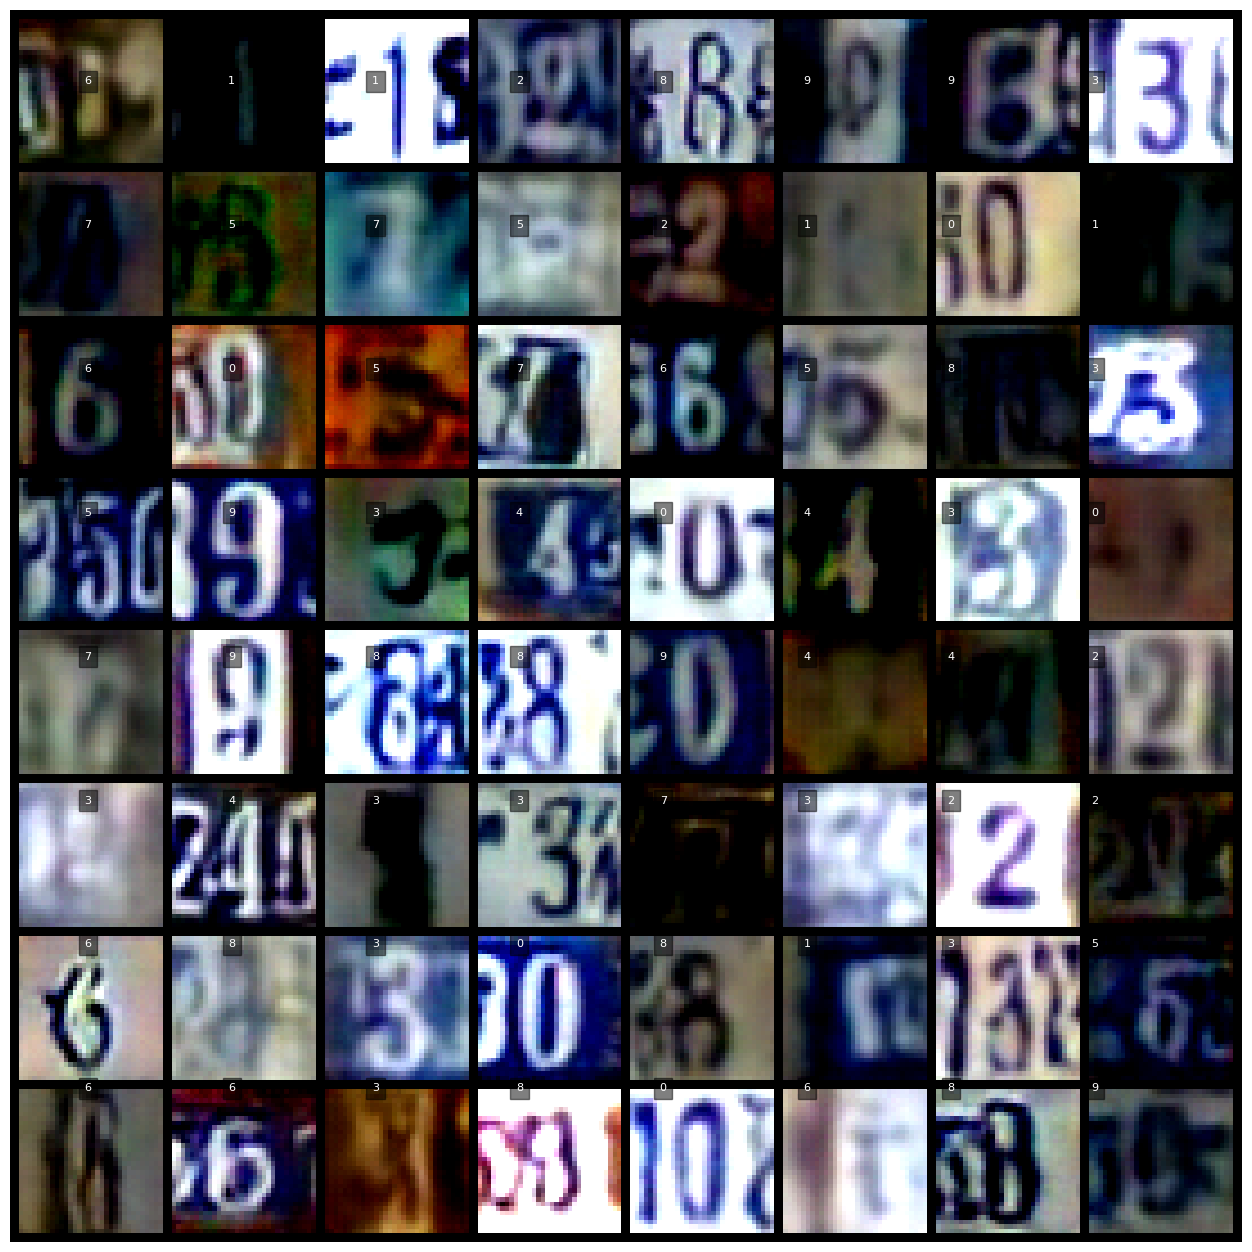

In [29]:
plt.figure(figsize=(16, 16))
plt.imshow(grid.cpu().permute(1, 2, 0)/0.5 - 0.5)

# Add labels to the grid
nrow = 8
for i in range(64):
    row = i // nrow
    col = i % nrow
    plt.text(col * 32 + 16 , row * 32 + 16 , str(labels[i].item()), color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))

plt.axis("off")
plt.show()

In [ ]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"Current GPU: {torch.cuda.current_device()}")
print(f"GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

In [ ]:
conv = nn.Conv2d(1, 1, 3, 1, 1).cuda()

# Input tensor
input_tensor = torch.randn(1, 1, 10, 10).cuda()

# Forward pass
output = conv(input_tensor)

print("cuDNN status: ", torch.backends.cudnn.enabled)
print("Output shape: ", output.shape)